In [ ]:
import os, sys, json, math, shutil, random, time
import random, datetime, importlib
from pathlib import Path

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from matplotlib import colormaps
from PIL import Image
from tqdm import tqdm
from scipy.ndimage import binary_fill_holes, binary_closing
from IPython.display import Image as IPyImage, display
import imageio
import hydra
from hydra.core.global_hydra import GlobalHydra
MainFolder = "/mnt/DATA3_SSD/Minsoo"
os.chdir(MainFolder) 
print(f"[INFO] Working directory set to: {os.getcwd()}")


[INFO] Working directory set to: /mnt/DATA3_SSD/Minsoo


In [2]:
#입력되어야할것
# cd /DATA3/Minsoo
# mv sam2 sam2_repo

In [3]:
GPU_INDEX = 0
device = torch.device(f"cuda:{GPU_INDEX}" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(f"[INFO] Using device: {device}")

VIDEO_DIR = Path(MainFolder) / "Input_Video"
VIDEO_EXTS = {".mp4", ".avi", ".mov", ".mkv", ".mpg", ".mpeg"}
video_files = [f for f in VIDEO_DIR.iterdir()
               if f.is_file() and f.suffix.lower() in VIDEO_EXTS]
if not video_files:
    raise FileNotFoundError(f"No video files found in the directory: {VIDEO_DIR}")
video_files.sort(key=lambda p: p.stat().st_mtime, reverse=True)
INPUT_VIDEO_PATH = str(video_files[0])

OUTPUT_BASE_DIR   = Path(MainFolder) / "Step_1_Seg"
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

SAM2_CONFIG_DIR = Path(MainFolder) / "sam2_repo/sam2/configs/sam2.1"
SAM2_CHECKPOINT = Path(MainFolder) / "sam2_repo/checkpoints/sam2.1_hiera_large.pt"

FILL_HOLE_AREA                    = 0
NON_OVERLAP_MASKS                 = True
ADD_ALL_FRAMES_TO_CORRECT_AS_COND = False

RUN_POINT_SEGMENTATION = True  
RUN_BOX_SEGMENTATION   = False 

def read_video_cv2(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return [], 0, (0,0), 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    FC  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    while True:
        ret, frm = cap.read()
        if not ret:
            break
        frames.append(frm)
    cap.release()
    return frames, fps, (W, H), FC


def get_video_resolution(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Could not open video file.")
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return width, height

W, H = get_video_resolution(INPUT_VIDEO_PATH)
print(W,H)


def generate_scaled_points_custom(W, H):
    pos_xs = [int(W * r) for r in [1/9, 4/7, 16/17]]
    pos_y = H // 2  

    neg_xs = [int(W * r) for r in [7/20, 15/20]]
    neg_y = H // 2 

    points = []
    for x in pos_xs:
        points.append((x, pos_y, 1))  # positive point
    for x in neg_xs:
        points.append((x, neg_y, 0))  # negative point

    return {1: points}


W, H = get_video_resolution(INPUT_VIDEO_PATH)
POINTS_PER_OBJ = generate_scaled_points_custom(W, H)
print(POINTS_PER_OBJ)

# BOXES_PER_OBJ = { 1: (305, 0, 469, 1080)}
BOXES_PER_OBJ = {}
SAVE_FRAME_INDICES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

MARKER_SIZE = 180
POS_COLOR   = 'lime'     # positive click
NEG_COLOR   = 'red'      # negative click
BOX_COLOR   = 'magenta'

[INFO] Using device: cuda:0
710 1080
{1: [(78, 540, 1), (405, 540, 1), (668, 540, 1), (248, 540, 0), (532, 540, 0)]}


/tmp/ipykernel_3148628/639956351.py:26: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(neg[:, 0], neg[:, 1], marker='x', s=MARKER_SIZE * 0.6,


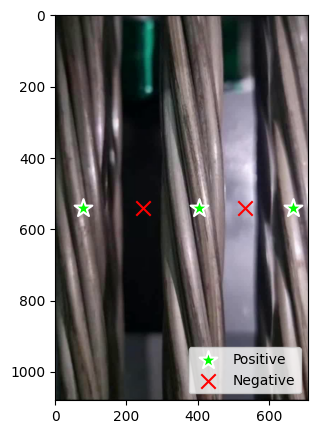

[DEBUG] Saved visualization to PNG → /mnt/DATA3_SSD/Minsoo/Step_1_Seg/debug_check/debug_points_boxes.png


In [4]:
def debug_visualize_first_frame(video_path, points_dict, boxes_dict, out_dir):
    """Overlay points and boxes on the first frame for debugging visualization"""
    frames, _, (W, H), _ = read_video_cv2(video_path)
    if not frames:
        print("[ERROR] Failed to read video.")
        return
    rgb0 = cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.imshow(rgb0)

    # If single object ID, use fixed color
    if RUN_POINT_SEGMENTATION:
        for oid, pts in points_dict.items():
            coords = [(x, y) for (x, y, l) in pts]
            labels = [l for (_, _, l) in pts]
            if len(coords) > 0:
                # Visualize points
                coords_np = np.array(coords)
                pos = coords_np[np.array(labels) == 1]
                neg = coords_np[np.array(labels) == 0]
                if len(pos):
                    ax.scatter(pos[:, 0], pos[:, 1], marker='*', s=MARKER_SIZE,
                               edgecolors='white', linewidths=1.5, color=POS_COLOR, label='Positive')
                if len(neg):
                    ax.scatter(neg[:, 0], neg[:, 1], marker='x', s=MARKER_SIZE * 0.6,
                               edgecolors='white', linewidths=1.5, color=NEG_COLOR, label='Negative')

    if RUN_BOX_SEGMENTATION:
        for oid, box in boxes_dict.items():
            x0, y0, x1, y1 = box
            ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                       linewidth=2, edgecolor=BOX_COLOR,
                                       facecolor=(0, 0, 0, 0)))

    ax.legend(loc='lower right')
    os.makedirs(out_dir, exist_ok=True)
    out_png = os.path.join(out_dir, "debug_points_boxes.png")
    plt.savefig(out_png, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"[DEBUG] Saved visualization to PNG → {out_png}")

# ── Run validation: visualize points on first frame
dbg_dir = os.path.join(OUTPUT_BASE_DIR, "debug_check")
debug_visualize_first_frame(INPUT_VIDEO_PATH, POINTS_PER_OBJ, BOXES_PER_OBJ, dbg_dir)


In [5]:
from sam2.build_sam import build_sam2_video_predictor
from sam2.sam2_video_predictor import SAM2VideoPredictor

In [6]:
def load_sam2_predictor(ckpt_path: str, device, **kwargs) -> SAM2VideoPredictor:
    """
    Creates a SAM2 Video Predictor object and sets postprocessing options.
    """
    GlobalHydra.instance().clear() 
    hydra.initialize_config_dir(version_base="1.3", config_dir=str(SAM2_CONFIG_DIR))


    predictor = build_sam2_video_predictor(
        config_file="sam2.1_hiera_l",
        ckpt_path = ckpt_path,
        device    = device,
        mode      = "eval",
        apply_postprocessing=True,
        hydra_overrides_extra=[],
        vos_optimized=False,
    )
    # 후처리 옵션 주입
    predictor.fill_hole_area                    = kwargs.get("fill_hole_area", FILL_HOLE_AREA)
    predictor.non_overlap_masks                 = kwargs.get("non_overlap_masks", NON_OVERLAP_MASKS)
    predictor.add_all_frames_to_correct_as_cond = kwargs.get("add_all_frames_to_correct_as_cond", ADD_ALL_FRAMES_TO_CORRECT_AS_COND)
    predictor.eval()
    return predictor

sam2_predictor = load_sam2_predictor(SAM2_CHECKPOINT, device)
print("[INFO] SAM2 Predictor ready.")


[INFO] SAM2 Predictor ready.


In [7]:
def segment_single_wire(
    predictor,         
    video_path,        
    output_dir,        
    points_per_obj,    
    boxes_per_obj={},  
    save_frame_indices=None,
    clear_old_points=True
):

    os.makedirs(output_dir, exist_ok=True)
    frames_bgr, fps, (W, H), FC = read_video_cv2(video_path)
    if FC == 0:
        print("[ERROR] Failed to read the video.")
        return

    inference_state = predictor.init_state(video_path=video_path)

    ANN_FRAME_IDX = 0  
    if RUN_POINT_SEGMENTATION:
        assert len(points_per_obj) == 1, "[ERROR] Only a single obj_id is supported."
        obj_id = list(points_per_obj.keys())[0]
        pts = points_per_obj[obj_id]
        coords = np.array([(x, y) for (x, y, _) in pts], dtype=np.float32)
        labels = np.array([lbl for *_, lbl in pts], dtype=np.int32)

        predictor.add_new_points_or_box(
            inference_state = inference_state,
            frame_idx       = ANN_FRAME_IDX,
            obj_id          = obj_id,
            points          = coords,
            labels          = labels,
            box             = None,
            clear_old_points= clear_old_points,  
            normalize_coords= False
        )
    if RUN_BOX_SEGMENTATION:
        assert len(boxes_per_obj) == 1, "[ERROR] Only a single obj_id is supported."
        obj_id = list(boxes_per_obj.keys())[0]
        box_xyxy = np.asarray(boxes_per_obj[obj_id], dtype=np.float32)
        predictor.add_new_points_or_box(
            inference_state = inference_state,
            frame_idx       = ANN_FRAME_IDX,
            obj_id          = obj_id,
            points          = None,
            labels          = None,
            box             = box_xyxy,
            clear_old_points= clear_old_points,
            normalize_coords= False
        )

    video_masks = {}  # video_masks[f_idx][obj_id] = binary mask
    for f_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        for i, oid in enumerate(out_obj_ids):
            logits = out_mask_logits[i]
            if logits.ndim == 3:
                logits = logits[0]  # (M,H,W)
            bin_mask = (logits > 0).cpu().numpy()
            video_masks.setdefault(f_idx, {})[oid] = bin_mask

    mask_arr = np.zeros((FC, H, W), dtype=np.uint8)
    for f_idx in range(FC):
        if f_idx in video_masks and obj_id in video_masks[f_idx]:
            mask_arr[f_idx] = video_masks[f_idx][obj_id].astype(np.uint8)

    out_npy = os.path.join(output_dir, f"mask_obj{obj_id}.npy")
    np.save(out_npy, mask_arr, allow_pickle=False)
    print(f"[INFO] Saved: {out_npy} | shape: {mask_arr.shape}")


    if save_frame_indices is None:
        save_frame_indices = [0, FC//2, FC-1]

    for idx in save_frame_indices:
        if idx < 0:
            idx = FC + idx
        if idx >= FC:
            continue
        bgr = frames_bgr[idx]
        out_vis = bgr.copy().astype(np.float32)
        if idx in video_masks and obj_id in video_masks[idx]:
            mask2d = video_masks[idx][obj_id]
            overlay = np.zeros_like(out_vis)
            overlay[..., 1] = mask2d * 255  
            


In [8]:
exp_name = "exp_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir_exp = os.path.join(OUTPUT_BASE_DIR, exp_name)
os.makedirs(output_dir_exp, exist_ok=True)
print(f"[INFO] Results will be saved to {output_dir_exp}")

single_vis_index = [0]

segment_single_wire(
    predictor      = sam2_predictor,
    video_path     = INPUT_VIDEO_PATH,
    output_dir     = output_dir_exp,      
    points_per_obj = POINTS_PER_OBJ,      
    boxes_per_obj  = BOXES_PER_OBJ,
    save_frame_indices = single_vis_index,  
    clear_old_points   = True
)


[INFO] Results will be saved to /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312


propagate in video: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]

[INFO] Saved: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/mask_obj1.npy | shape: (12, 1080, 710)


Mask shape: (12, 1080, 710)
Video frame count: 12
Selected frame indices: [ 0  1  2  3  4  6  7  8  9 11]
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0000.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0001.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0002.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0003.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0004.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0006.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0007.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_0008.png
[INFO] Saved visualization: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/vis_frame_000

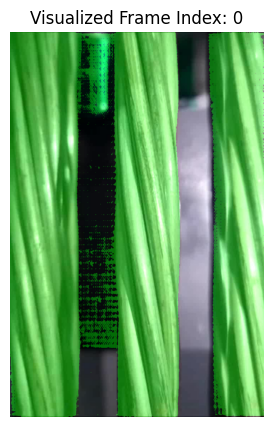

In [9]:
# --- Configuration ---
# Path to the saved mask file (update as needed)
mask_path = output_dir_exp + "/mask_obj1.npy"
# Path to the original video (should match the input video used for segmentation)
video_path = INPUT_VIDEO_PATH
# Directory to save visualization results (create if not exist)
vis_output_dir = output_dir_exp
os.makedirs(vis_output_dir, exist_ok=True)

# --- Load mask file ---
mask_arr = np.load(mask_path)
# mask_arr shape: (total_frames, H, W)
total_frames, H, W = mask_arr.shape
print(f"Mask shape: {mask_arr.shape}")

# --- Read video frames using OpenCV ---
def read_video_cv2(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("[ERROR] Failed to open video.")
        return []
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

frames_bgr = read_video_cv2(video_path)
if len(frames_bgr) != total_frames:
    print("Warning: Number of video frames does not match mask file.")
print(f"Video frame count: {len(frames_bgr)}")

# --- Select representative frame indices (about 10 evenly spread) ---
num_vis = 10
indices = np.linspace(0, total_frames - 1, num=num_vis, dtype=int)
print(f"Selected frame indices: {indices}")

# --- Generate visualizations ---
# Define overlay color and alpha value
overlay_color = (0, 255, 0)  # Green in BGR
alpha = 0.4  # Transparency

for idx in indices:
    if idx < 0 or idx >= total_frames:
        continue
    frame = frames_bgr[idx].copy()
    mask2d = mask_arr[idx]  # Binary mask for this frame

    # Create an overlay image with the same shape as the frame
    overlay = np.zeros_like(frame, dtype=np.uint8)
    # Fill overlay where mask is 1 with the defined overlay color
    overlay[..., 0] = mask2d * overlay_color[0]  # Blue
    overlay[..., 1] = mask2d * overlay_color[1]  # Green
    overlay[..., 2] = mask2d * overlay_color[2]  # Red

    # Blend original frame and overlay with alpha transparency
    vis_frame = cv2.addWeighted(frame, 1.0, overlay, alpha, 0)

    # Save the result as a PNG (e.g., vis_frame_0001.png)
    out_path = os.path.join(vis_output_dir, f"vis_frame_{idx:04d}.png")
    cv2.imwrite(out_path, vis_frame)
    print(f"[INFO] Saved visualization: {out_path}")

# --- Optional: Visualize one frame using Matplotlib ---
idx_show = indices[0]
vis_frame = cv2.cvtColor(
    cv2.imread(os.path.join(vis_output_dir, f"vis_frame_{idx_show:04d}.png")),
    cv2.COLOR_BGR2RGB
)
plt.figure(figsize=(8, 5))
plt.title(f"Visualized Frame Index: {idx_show}")
plt.imshow(vis_frame)
plt.axis("off")
plt.show()

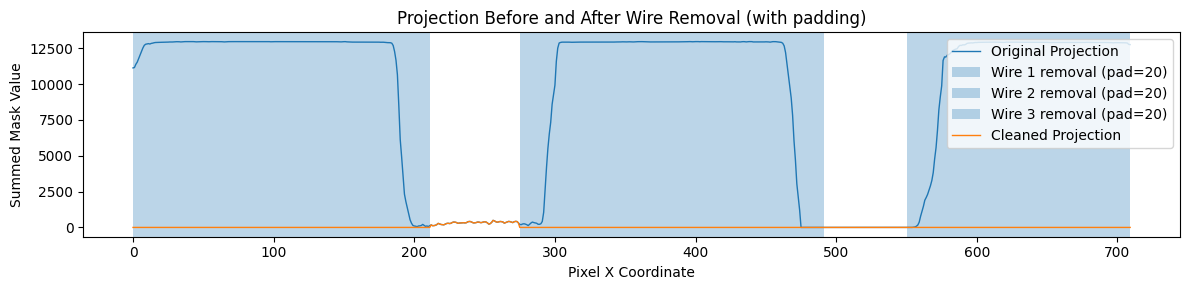

Saved cleaned mask for wire 1: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/mask_wire1_cleaned.npy (pad=20)
Saved cleaned mask for wire 2: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/mask_wire2_cleaned.npy (pad=20)
Saved cleaned mask for wire 3: /mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/mask_wire3_cleaned.npy (pad=20)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

def detect_wire_regions(mask: np.ndarray, threshold_ratio: float = 0.5):
    proj = mask.sum(axis=(0, 1))
    th = proj.mean() * threshold_ratio
    binary = (proj > th).astype(int)
    labels, num = label(binary)
    regions = []
    for lab in range(1, num + 1):
        xs = np.where(labels == lab)[0]
        regions.append((int(xs.min()), int(xs.max())))
    regions.sort(key=lambda x: x[0])  # Sort by x_start
    return regions  # Not mapped yet

def clean_and_plot_auto(mask: np.ndarray, threshold_ratio: float = 0.5, pad_pixels: int = 20):
    T, H, W = mask.shape
    regions = detect_wire_regions(mask, threshold_ratio)

    padded_map = {}
    for i, (x0, x1) in enumerate(regions):
        wire_id = i + 1  
        x0p = max(0, x0 - pad_pixels)
        x1p = min(W - 1, x1 + pad_pixels)
        padded_map[wire_id] = (x0p, x1p)

    proj_before = mask.sum(axis=(0, 1))
    cleaned = mask.copy()

    plt.figure(figsize=(12, 3))
    plt.plot(proj_before, label='Original Projection', linewidth=1)

    for wire_id, (x0, x1) in padded_map.items():
        cleaned[:, :, x0:x1+1] = 0
        plt.axvspan(x0, x1, alpha=0.3, label=f'Wire {wire_id} removal (pad={pad_pixels})')

    proj_after = cleaned.sum(axis=(0, 1))
    plt.plot(proj_after, label='Cleaned Projection', linewidth=1)

    plt.title("Projection Before and After Wire Removal (with padding)")
    plt.xlabel("Pixel X Coordinate")
    plt.ylabel("Summed Mask Value")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return cleaned, padded_map


mask_path = output_dir_exp + "/mask_obj1.npy"
mask = np.load(mask_path)

cleaned_mask, wire_map_padded = clean_and_plot_auto(
    mask,
    threshold_ratio=0.5,
    pad_pixels=20
)

for wire_id, (x0, x1) in wire_map_padded.items():
    single_clean = mask.copy()
    single_clean[:, :, x0:x1+1] = 0
    out_path = f"{output_dir_exp}/mask_wire{wire_id}_cleaned.npy"
    np.save(out_path, single_clean)
    print(f"Saved cleaned mask for wire {wire_id}: {out_path} (pad=20)")


In [11]:
print(wire_map_padded[1][1], wire_map_padded[2][0])

211 275


📐 Loaded mask shape: (12, 1080, 710)
{1: (0, 211), 2: (275, 491), 3: (550, 709)}


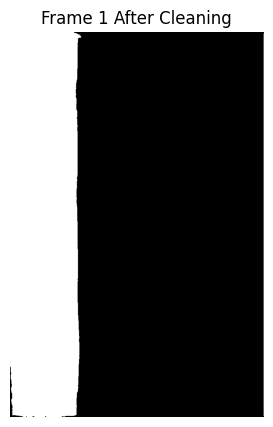

In [12]:
import numpy as np
import matplotlib.pyplot as plt

mask_path = output_dir_exp + "/mask_obj1.npy"  
mask = np.load(mask_path)  

print("📐 Loaded mask shape:", mask.shape)  
print(wire_map_padded)


x_start, x_end = wire_map_padded[1][1], wire_map_padded[3][1]
mask[:, :, x_start:x_end] = 0

np.save(output_dir_exp + "/mask_obj1_cleaned.npy", mask)

frame_idx = 1
plt.figure(figsize=(6,5))
plt.imshow(mask[frame_idx], cmap='gray')
plt.title(f"Frame {frame_idx} After Cleaning")
plt.axis('off')
plt.show()


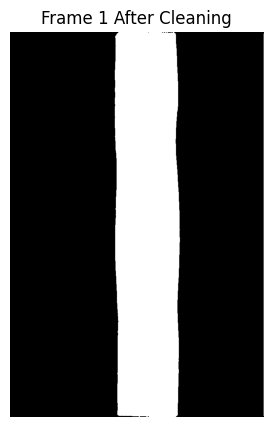

In [13]:
mask = np.load(mask_path) 
x_start, x_end = wire_map_padded[2][1], wire_map_padded[3][1]
mask[:, :, x_start:x_end] = 0

x_start, x_end = wire_map_padded[1][0], wire_map_padded[2][0]
mask[:, :, x_start:x_end] = 0


np.save(output_dir_exp + "/mask_obj2_cleaned.npy", mask)

frame_idx = 1
plt.figure(figsize=(6,5))
plt.imshow(mask[frame_idx], cmap='gray')
plt.title(f"Frame {frame_idx} After Cleaning")
plt.axis('off')
plt.show()


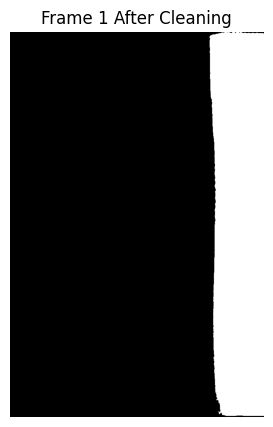

In [14]:
mask = np.load(mask_path) 
x_start, x_end = wire_map_padded[1][0], wire_map_padded[3][0]
mask[:, :, x_start:x_end] = 0

np.save(output_dir_exp + "/mask_obj3_cleaned.npy", mask)

frame_idx = 1
plt.figure(figsize=(6,5))
plt.imshow(mask[frame_idx], cmap='gray')
plt.title(f"Frame {frame_idx} After Cleaning")
plt.axis('off')
plt.show()


In [15]:
module_path = Path(MainFolder) /"Depth-Anything-V2"
sys.path.append(module_path)

In [16]:
MODEL_ROOT  = Path(MainFolder) / "Depth-Anything-V2"
VIDEO_PATH   = INPUT_VIDEO_PATH
OUTPUT_ROOT = Path(MainFolder) / "Step_2_Depth_Results"

FRAMES_TO_PROCESS = [0, 1, 2, 3, 4, 5, 6 ,7, 8, 9, 10]


ENCODER = "vitl"
INPUT_SIZE = 518                
SAVE_CSV   = True                
sys.path.append(str(MODEL_ROOT)) 

exp_idx = 1
while (OUTPUT_ROOT / f"exp{exp_idx}" ).exists():
    exp_idx += 1
EXP_DIR = OUTPUT_ROOT / f"exp{exp_idx}"
EXP_DIR.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Results will be saved in: {EXP_DIR}")
print(f"[INFO] Processing the following frames: {FRAMES_TO_PROCESS}")

[INFO] Results will be saved in: /mnt/DATA3_SSD/Minsoo/Step_2_Depth_Results/exp2
[INFO] Processing the following frames: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [17]:
CMAP = colormaps.get_cmap("Spectral_r")

def get_video_info(cap: cv2.VideoCapture):
    fps   = cap.get(cv2.CAP_PROP_FPS)
    count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return fps, count, w, h

def build_fname(base: str, frame_idx: int, suffix: str):
    return f"{base}_frame{frame_idx:04d}_{suffix}"

def depth_to_color(depth_norm: np.ndarray):
    depth_color = (CMAP(depth_norm)[:, :, :3] * 255).astype(np.uint8)
    return cv2.cvtColor(depth_color, cv2.COLOR_RGB2BGR)

def ensure_uint8(depth: np.ndarray):
    d = depth.copy()
    d = (d - d.min()) / (d.max() - d.min() + 1e-8) * 255.0
    return d.astype(np.uint8)

In [18]:


project_root = os.getcwd()
depth_anything_path = Path(MainFolder) / "Depth-Anything-V2/Depth-Anything-V2"
sys.path.append(str(depth_anything_path))

DepthAnythingV2 = importlib.import_module("depth_anything_v2.dpt").DepthAnythingV2
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"[INFO] Using device: {DEVICE}")


model_cfgs = {
    "vits": dict(encoder="vits", features=64,  out_channels=[48, 96, 192, 384]),
    "vitb": dict(encoder="vitb", features=128, out_channels=[96, 192, 384, 768]),
    "vitl": dict(encoder="vitl", features=256, out_channels=[256, 512, 1024, 1024]),
    "vitg": dict(encoder="vitg", features=384, out_channels=[1536, 1536, 1536, 1536]),
}
model = DepthAnythingV2(**model_cfgs[ENCODER])
ckpt_path = MODEL_ROOT / "checkpoints" / f"depth_anything_v2_{ENCODER}.pth"
model.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
model = model.to(DEVICE).eval()
print(f"[INFO] Successfully loaded model from: {ckpt_path.name}")

[INFO] Using device: cuda
[INFO] Successfully loaded model from: depth_anything_v2_vitl.pth


In [19]:
cap = cv2.VideoCapture(str(VIDEO_PATH))
if not cap.isOpened():
    raise FileNotFoundError(f"Failed to open video: {VIDEO_PATH}")

fps, total_frames, vid_w, vid_h = get_video_info(cap)
print(f"[INFO] Video FPS: {fps}, Total Frames: {total_frames}, Resolution: {vid_w}x{vid_h}")

VIDEO_PATH = Path(VIDEO_PATH)
base_name = VIDEO_PATH.stem

for idx in FRAMES_TO_PROCESS:
    if idx >= total_frames:
        print(f"[WARN] Requested frame {idx} > total frames {total_frames - 1} → skipped")
        continue

    # ── Extract frame ─────────────────────────────────────────────────────
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame_bgr = cap.read()
    if not ret:
        print(f"[ERROR] Failed to read frame {idx}")
        continue
    h, w = frame_bgr.shape[:2]

    # ── Depth inference ─────────────────────────────────────────────────────
    depth_raw = model.infer_image(frame_bgr, input_size=INPUT_SIZE)  # float32, HxW
    depth_u8  = ensure_uint8(depth_raw)                              # uint8, 0–255
    depth_col = depth_to_color(depth_u8)                             # BGR colormap

    # ── Save paths and filenames ────────────────────────────────────────────
    fname_base = build_fname(base_name, idx, "depth")
    # Save images
    cv2.imwrite(str(EXP_DIR / f"{fname_base}Color.png"), depth_col)
    cv2.imwrite(str(EXP_DIR / f"{fname_base}Gray.png"), cv2.cvtColor(depth_u8, cv2.COLOR_GRAY2BGR))
    # Save raw depth as .npy
    np.save(str(EXP_DIR / f"{fname_base}.npy"), depth_raw.astype(np.float32))
    # Save CSV (y,x,depth)
    if SAVE_CSV:
        yx = np.stack(np.meshgrid(np.arange(h), np.arange(w), indexing="ij"), -1).reshape(-1, 2)
        flat_depth = depth_raw.reshape(-1, 1)
        yx_depth = np.hstack([yx, flat_depth])
        np.savetxt(
            str(EXP_DIR / f"{fname_base}.csv"),
            yx_depth,
            fmt=["%d", "%d", "%.6f"],
            delimiter=",",
            header="y,x,depth",
            comments=""
        )
    print(f"[SAVE] Frame {idx} → Files with prefix '{fname_base}*' saved successfully")

cap.release()
print("[DONE] All requested frames processed.")

[INFO] Video FPS: 10.0, Total Frames: 12, Resolution: 710x1080
[SAVE] Frame 0 → Files with prefix 'Video_frame0000_depth*' saved successfully
[SAVE] Frame 1 → Files with prefix 'Video_frame0001_depth*' saved successfully
[SAVE] Frame 2 → Files with prefix 'Video_frame0002_depth*' saved successfully
[SAVE] Frame 3 → Files with prefix 'Video_frame0003_depth*' saved successfully
[SAVE] Frame 4 → Files with prefix 'Video_frame0004_depth*' saved successfully
[SAVE] Frame 5 → Files with prefix 'Video_frame0005_depth*' saved successfully
[SAVE] Frame 6 → Files with prefix 'Video_frame0006_depth*' saved successfully
[SAVE] Frame 7 → Files with prefix 'Video_frame0007_depth*' saved successfully
[SAVE] Frame 8 → Files with prefix 'Video_frame0008_depth*' saved successfully
[SAVE] Frame 9 → Files with prefix 'Video_frame0009_depth*' saved successfully
[SAVE] Frame 10 → Files with prefix 'Video_frame0010_depth*' saved successfully
[DONE] All requested frames processed.


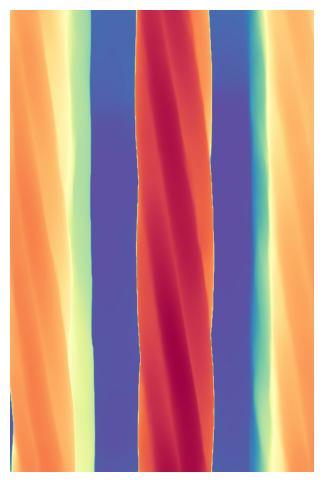

In [20]:
sample_idx = FRAMES_TO_PROCESS[0]
fname_show = build_fname(base_name, sample_idx, "depthColor.png")
full_path = EXP_DIR / fname_show

if os.path.exists(full_path):
    img = cv2.cvtColor(cv2.imread(str(full_path)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,6))
    plt.imshow(img)
    plt.axis('off')
    # plt.title(fname_show)
    plt.show()
else:
    print("File not found:", full_path)


In [21]:
print(MODEL_ROOT)

/mnt/DATA3_SSD/Minsoo/Depth-Anything-V2


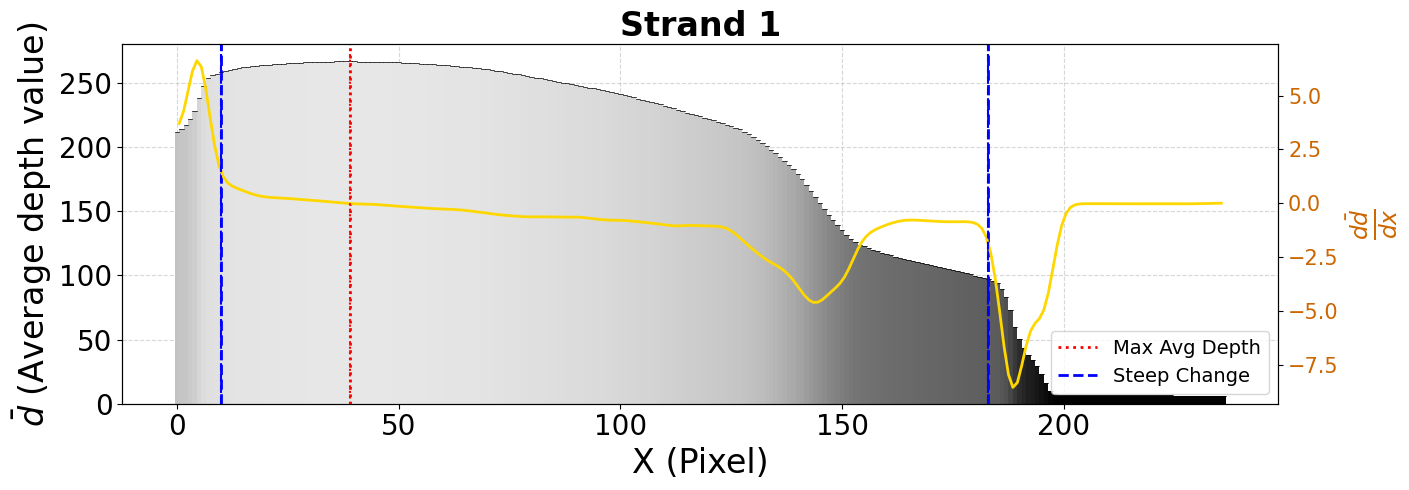

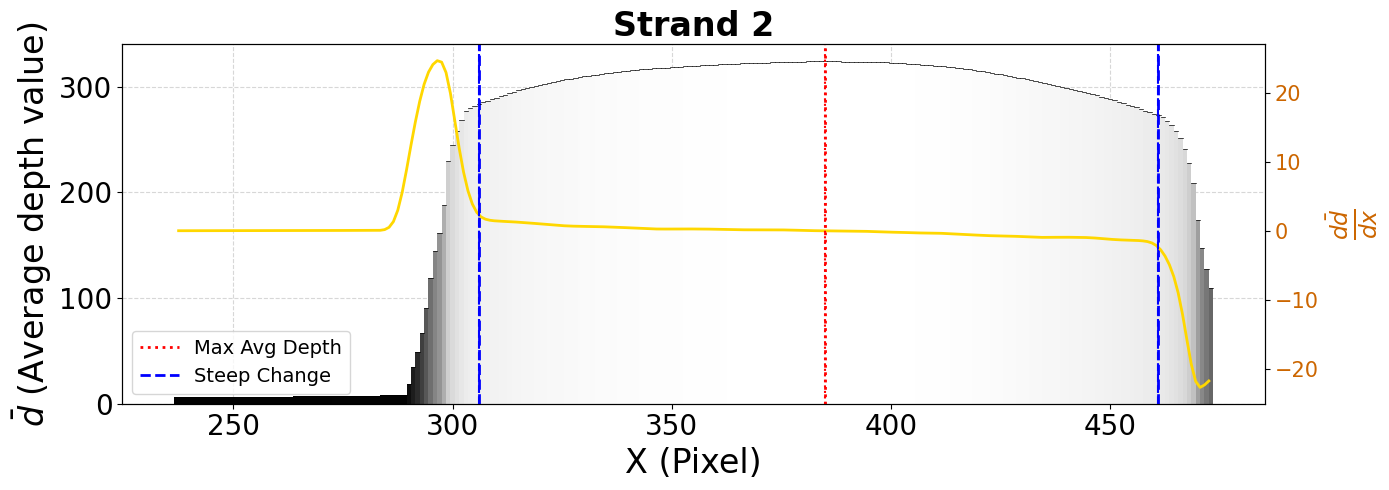

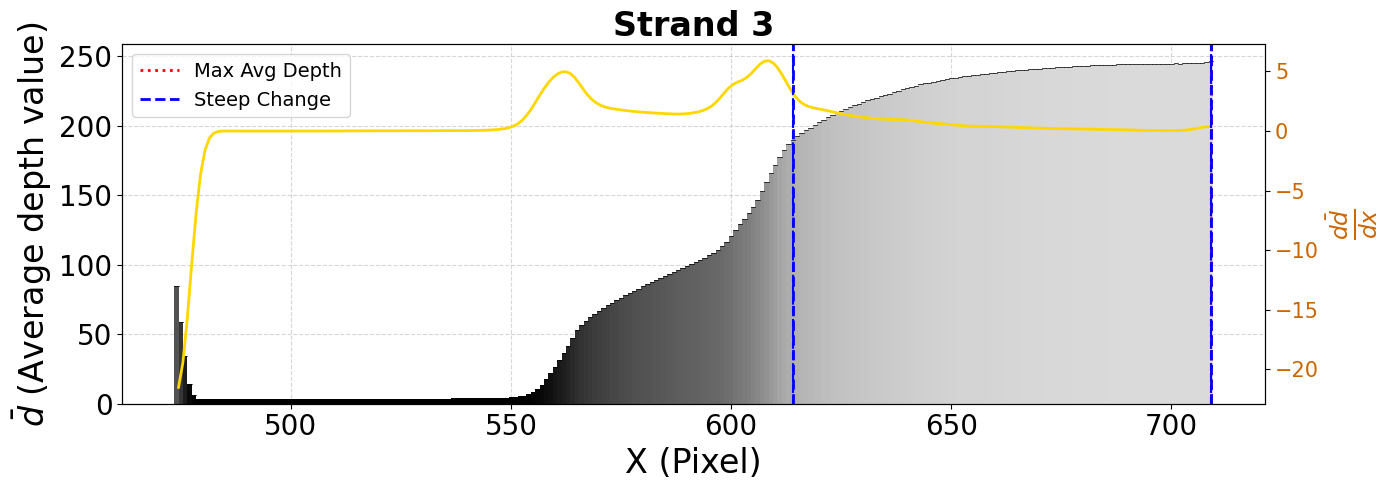

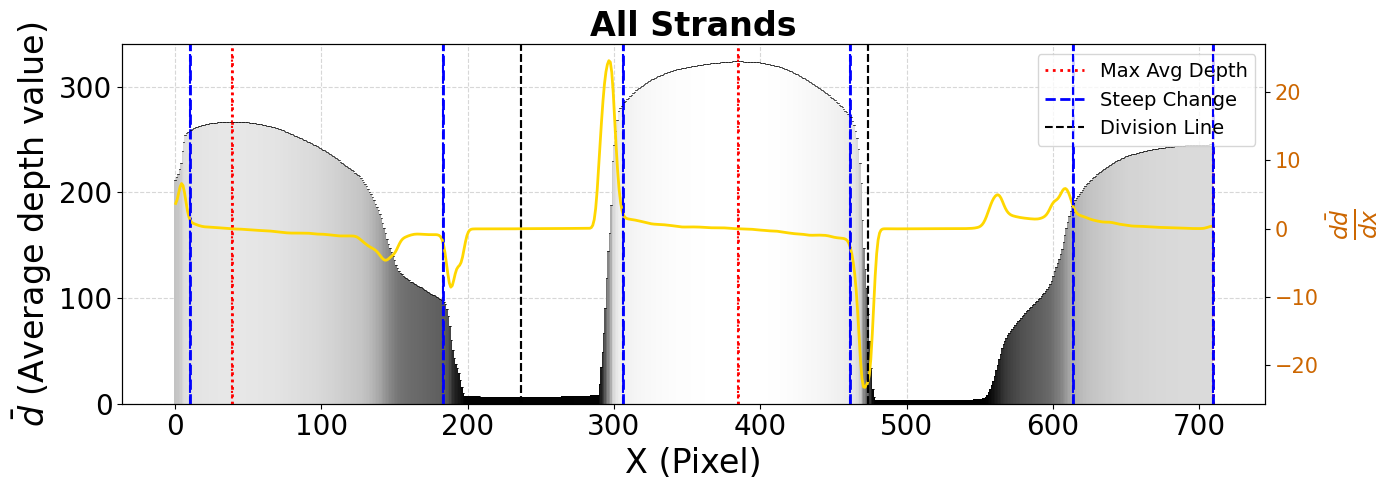

Steep Change x values (threshold = 0.5):
[10, 183, 306, 461, 614, 709]


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

csv_path = EXP_DIR / "Video_frame0001_depth.csv"

df = pd.read_csv(csv_path)
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['depth'] = pd.to_numeric(df['depth'], errors='coerce')
df = df.dropna()

bins = [(0, W/3), (W/3, 2*W/3), (2*W/3, W)]
labels = ['Strand 1', 'Strand 2', 'Strand 3']
legend_locs = {
    'Strand 1': 'lower right',
    'Strand 2': 'lower left',
    'Strand 3': 'upper left'
}

def draw_bar_with_top_edge(ax, x_vals, y_vals, colors):
    bar_width = 1.0
    ax.bar(x_vals, y_vals, color=colors, width=bar_width, edgecolor='none', zorder=2)
    for x, y in zip(x_vals, y_vals):
        ax.plot([x - bar_width/2, x + bar_width/2], [y, y], color='black', linewidth=0.5, zorder=3)

global_peaks = []
global_steeps = []

def plot_combined(x_vals, avg_vals, label, global_vmin, global_vmax, threshold=0.13, sigma=2, is_overall=False):
    dx = np.diff(x_vals)
    dy = np.diff(avg_vals)
    raw_derivative = dy / dx
    smoothed_derivative = gaussian_filter1d(raw_derivative, sigma=sigma)
    x_mid = (x_vals[:-1] + x_vals[1:]) / 2

    peak_idx = np.argmax(avg_vals)
    peak_x = x_vals[peak_idx]

    d2 = np.diff(smoothed_derivative)
    d2_abs = np.abs(d2)
    x_mid2 = (x_mid[:-1] + x_mid[1:]) / 2
    steep_change_indices = np.where(d2_abs > threshold)[0]
    steep_x_candidates = x_mid2[steep_change_indices]

    closest_steep_x = []
    if label == 'Strand 2' and len(steep_x_candidates) > 0:
        left = steep_x_candidates[steep_x_candidates < peak_x]
        right = steep_x_candidates[steep_x_candidates > peak_x]
        if len(left) > 0:
            closest_steep_x.append(left[np.argmin(np.abs(left - peak_x))])
        if len(right) > 0:
            closest_steep_x.append(right[np.argmin(np.abs(right - peak_x))])

    elif label == 'Strand 1' and len(steep_x_candidates) > 0:
        left  = steep_x_candidates[steep_x_candidates <  peak_x]
        right = steep_x_candidates[steep_x_candidates >  peak_x]
        if len(left) > 0:
            closest_steep_x.append(left[np.argmin(np.abs(left - peak_x))])
        else:
            closest_steep_x.append(0) 
        if len(right) > 0:
            closest_steep_x.append(right[np.argmin(np.abs(right - peak_x))])


    elif label == 'Strand 3' and len(steep_x_candidates) > 0:
        strand3_min = x_vals[0]
        strand3_max = x_vals[-1]
        strand3_candidates = steep_x_candidates[(steep_x_candidates >= strand3_min) & (steep_x_candidates <= strand3_max)]

        if len(strand3_candidates) > 0:
            peak_left  = strand3_candidates[strand3_candidates < peak_x]
            peak_right = strand3_candidates[strand3_candidates > peak_x]

            if len(peak_left) > 0:
                closest_steep_x.append(peak_left[np.argmin(np.abs(peak_left - peak_x))])
            if len(peak_right) > 0:
                closest_steep_x.append(peak_right[np.argmin(np.abs(peak_right - peak_x))])
            else:
                closest_steep_x.append(strand3_max) 

    if not is_overall:
        global_peaks.append(peak_x)
        global_steeps.extend(closest_steep_x)

    normed = (avg_vals - global_vmin) / (global_vmax - global_vmin)
    cmap = plt.get_cmap('Greys')
    colors = [cmap(1 - val) for val in normed]

    fig, ax1 = plt.subplots(figsize=(14, 5))
    draw_bar_with_top_edge(ax1, x_vals, avg_vals, colors)
    ax1.set_ylabel(r"$\bar{d}$ (Average depth value)", fontsize=24)
    ax1.set_title(f"{label}", fontsize=24, fontweight='bold')
    ax1.tick_params(axis='both', labelsize=20)
    ax1.grid(True, linestyle='--', alpha=0.5)

    if is_overall:
        for px in global_peaks:
            ax1.axvline(x=px, color='red', linestyle=':', linewidth=2.0)
        for sx in global_steeps:
            ax1.axvline(x=sx, color='blue', linestyle='--', linewidth=2.0)
        ax1.axvline(x=W/3, color='black', linestyle='--', linewidth=1.5)
        ax1.axvline(x=2*W/3, color='black', linestyle='--', linewidth=1.5)
    else:
        ax1.axvline(x=peak_x, color='red', linestyle=':', linewidth=2.0)
        for sx in closest_steep_x:
            ax1.axvline(x=sx, color='blue', linestyle='--', linewidth=2.0)

    ax2 = ax1.twinx()
    ax2.plot(x_mid, smoothed_derivative, color='gold', linewidth=2)
    ax2.set_ylabel(r"$\frac{d\bar{d}}{dx}$", fontsize=24, color='#cc6600')
    ax2.tick_params(axis='y', labelsize=15, labelcolor='#cc6600')

    if is_overall:
        for px in global_peaks:
            ax2.axvline(x=px, color='red', linestyle=':', linewidth=1.5)
        for sx in global_steeps:
            ax2.axvline(x=sx, color='blue', linestyle='--', linewidth=1.5)
        ax2.axvline(x=W/3, color='black', linestyle='--', linewidth=1.5)
        ax2.axvline(x=2*W/3, color='black', linestyle='--', linewidth=1.5)

        legend_lines = [
            plt.Line2D([0], [0], color='red', linestyle=':', linewidth=2),
            plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=2),
            plt.Line2D([0], [0], color='black', linestyle='--', linewidth=1.5)
        ]
        ax1.legend(legend_lines, ['Max Avg Depth', 'Steep Change', 'Division Line'],
                   loc='upper right', fontsize=14)
    else:
        ax2.axvline(x=peak_x, color='red', linestyle=':', linewidth=1.5)
        for sx in closest_steep_x:
            ax2.axvline(x=sx, color='blue', linestyle='--', linewidth=1.5)

        legend_lines = [
            plt.Line2D([0], [0], color='red', linestyle=':', linewidth=2),
            plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=2)
        ]
        ax1.legend(legend_lines, ['Max Avg Depth', 'Steep Change'],
                   loc=legend_locs[label], fontsize=14)

    ax1.set_xlabel("X (Pixel)", fontsize=24)
    fig.tight_layout()
    plt.show()

global_avg = df.groupby('x')['depth'].mean()
global_vmin = global_avg.min()
global_vmax = global_avg.max()


threshold = 0.5
sigma = 2

for (start, end), label in zip(bins, labels):
    section = df[(df['x'] >= start) & (df['x'] < end)]
    avg_depth_by_x = section.groupby('x')['depth'].mean()
    x_vals = avg_depth_by_x.index.values
    avg_vals = avg_depth_by_x.values
    plot_combined(x_vals, avg_vals, label, global_vmin, global_vmax,
                  threshold=threshold, sigma=sigma)

all_avg = df.groupby('x')['depth'].mean()
x_all = all_avg.index.values
avg_all = all_avg.values
plot_combined(x_all, avg_all, "All Strands", global_vmin, global_vmax,
              threshold=threshold, sigma=sigma, is_overall=True)

unique_steep_x = sorted(set(np.round(global_steeps).astype(int)))

print("Steep Change x values (threshold = {}):".format(threshold))
print(unique_steep_x)

steep_x_df = pd.DataFrame({'steep_x': unique_steep_x})
steep_x_df.to_csv("steep_x_positions.csv", index=False)


In [23]:
FRAME_INDEX = 1
CUSTOM_THRESHOLD_OVERRIDE = None  
EXPANSION_PX = 5
FILL_HOLES   = True
DISPLAY_INLINE = True


In [24]:
print(EXP_DIR)
print(full_path)
print(output_dir_exp)

/mnt/DATA3_SSD/Minsoo/Step_2_Depth_Results/exp2
/mnt/DATA3_SSD/Minsoo/Step_2_Depth_Results/exp2/Video_frame0000_depthColor.png
/mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312


In [25]:

output_dir_exp = Path(output_dir_exp) 

# [1] 파일 경로 설정
filename = full_path.name
frame_index_str = filename.split("_")[1]  # 'frame000000'
frame_num = int(frame_index_str.replace("frame", ""))
new_frame_num = frame_num + 1
new_frame_str = f"frame{new_frame_num:04d}"

# 새로운 파일명 생성
new_filename = filename.replace(frame_index_str, new_frame_str)
new_filename = new_filename.replace("depthColor.png", "depth.npy")

# DEPTH_PATH 생성
DEPTH_PATH = full_path.parent / new_filename

print(f"[INFO] DEPTH_PATH = {DEPTH_PATH}")
WIRE_MASK_PATHS = [
    output_dir_exp / "mask_obj1_cleaned.npy",
    output_dir_exp / "mask_obj2_cleaned.npy",
    output_dir_exp / "mask_obj3_cleaned.npy",
]
SAVE_DIR = Path(MainFolder) / "sam2_depth_refined_output"
SAVE_DIR.mkdir(exist_ok=True)

[INFO] DEPTH_PATH = /mnt/DATA3_SSD/Minsoo/Step_2_Depth_Results/exp2/Video_frame0001_depth.npy


In [26]:
print(DEPTH_PATH)
print(WIRE_MASK_PATHS)

/mnt/DATA3_SSD/Minsoo/Step_2_Depth_Results/exp2/Video_frame0001_depth.npy
[PosixPath('/mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/mask_obj1_cleaned.npy'), PosixPath('/mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/mask_obj2_cleaned.npy'), PosixPath('/mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312/mask_obj3_cleaned.npy')]


In [27]:
print(fname_base)
print(EXP_DIR)

Video_frame0010_depth
/mnt/DATA3_SSD/Minsoo/Step_2_Depth_Results/exp2


In [28]:
print(output_dir_exp)

/mnt/DATA3_SSD/Minsoo/Step_1_Seg/exp_20250623_164312


{1: (10, 183), 2: (306, 461), 3: (614, 709)}


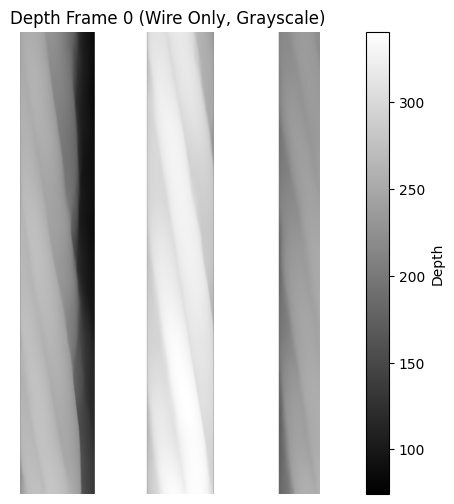

✅ Saved wire-only depth: /mnt/DATA3_SSD/Minsoo/Step_3_ROI/depth_cleaned.npy


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

mask_path = Path(output_dir_exp) / "mask_obj1.npy"

mask = np.load(mask_path)


depth_path = DEPTH_PATH 
depth_all = np.load(depth_path) 
depth_cleaned = depth_all.copy()


wire_map_padded = {i + 1: (unique_steep_x[2*i], unique_steep_x[2*i+1]) for i in range(len(unique_steep_x) // 2)}
print(wire_map_padded)

if depth_cleaned.ndim == 3: 
    wire_only_mask = np.zeros_like(depth_cleaned, dtype=bool)
    for wire_id, (x0, x1) in wire_map_padded.items():
        wire_only_mask[:, :, x0:x1+1] = True
    depth_cleaned[~wire_only_mask] = np.nan

elif depth_cleaned.ndim == 2:
    wire_only_mask = np.zeros_like(depth_cleaned, dtype=bool)
    for wire_id, (x0, x1) in wire_map_padded.items():
        wire_only_mask[:, x0:x1+1] = True
    depth_cleaned[~wire_only_mask] = np.nan

else:
    raise ValueError("The depth data has an unexpected number of dimensions.")

sample_idx = 0
plt.figure(figsize=(12, 6))

if depth_cleaned.ndim == 3:
    frame = depth_cleaned[sample_idx]
else:
    frame = depth_cleaned

plt.imshow(
    frame,
    cmap='gray',           
    vmin=np.nanmin(frame), 
    vmax=np.nanmax(frame)
)
plt.title(f"Depth Frame {sample_idx} (Wire Only, Grayscale)")
plt.colorbar(label='Depth')
plt.axis('off')
plt.show()

out_depth_path = Path(MainFolder) / "Step_3_ROI/depth_cleaned.npy"
np.save(out_depth_path, depth_cleaned)
print(f"✅ Saved wire-only depth: {out_depth_path}")


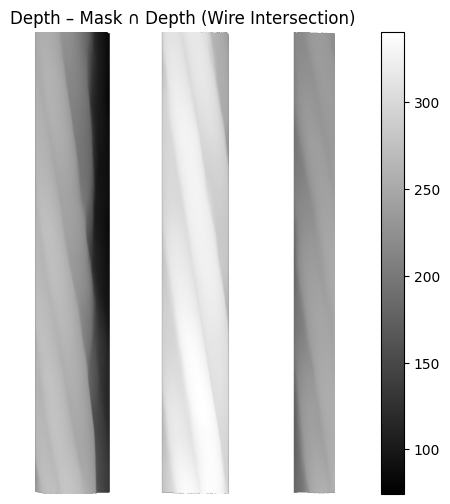

Saved intersection depth: /mnt/DATA3_SSD/Minsoo/Step_3_ROI/depth_wire_intersection.npy


In [30]:
import numpy as np
import matplotlib.pyplot as plt

if mask.ndim == 3:                    # (T, H, W)
    T, H, W = mask.shape
    mask_wire_region = np.zeros_like(mask, dtype=bool)
    for (x0, x1) in wire_map_padded.values():
        mask_wire_region[:, :, x0:x1+1] = mask[:, :, x0:x1+1] > 0
else:                                 # (H, W)
    H, W = mask.shape
    mask_wire_region = np.zeros_like(mask, dtype=bool)
    for (x0, x1) in wire_map_padded.values():
        mask_wire_region[:, x0:x1+1] = mask[:, x0:x1+1] > 0


if depth_cleaned.ndim == 2 and mask_wire_region.ndim == 3:
    depth_cleaned = np.repeat(depth_cleaned[None, ...], mask_wire_region.shape[0], axis=0)

depth_valid_region = ~np.isnan(depth_cleaned)


if mask_wire_region.shape != depth_valid_region.shape:
    raise ValueError(f"Shape mismatch after alignment: mask {mask_wire_region.shape} vs depth {depth_valid_region.shape}")


intersection_region = np.logical_and(mask_wire_region, depth_valid_region)
depth_intersection_only = np.where(intersection_region, depth_cleaned, np.nan)

plt.figure(figsize=(12, 6))
if depth_intersection_only.ndim == 3:
    plt.imshow(depth_intersection_only[5], cmap='gray')
else:
    plt.imshow(depth_intersection_only, cmap='gray')
plt.title("Depth – Mask ∩ Depth (Wire Intersection)")
plt.colorbar(); plt.axis('off'); plt.show()

out_inter_path = Path(MainFolder) / "Step_3_ROI/depth_wire_intersection.npy"
np.save(out_depth_path, depth_intersection_only)
print(f"Saved intersection depth: {out_inter_path}")



In [31]:
mask_data = np.load(out_depth_path)  
frame1_mask = mask_data[1]
np.save(Path(MainFolder)/"frame1_wire1_refined.npy", frame1_mask)


In [32]:

sys.path.append(str(Path(MainFolder) / "co-tracker"))

In [33]:
import os, cv2, random, math, numpy as np, pandas as pd
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

# CoTracker
from cotracker.predictor import CoTrackerPredictor
from cotracker.utils.visualizer import read_video_from_path

# Paths and model configuration
VIDEO_PATH      = INPUT_VIDEO_PATH
MASK_PATH       = Path(MainFolder) / "Step_3_ROI/frame1_wire1_refined.npy"
CHECKPOINT_PATH = Path(MainFolder) / "co-tracker/cotracker/checkpoints/scaled_offline.pth"
OUTPUT_BASE_DIR = Path(MainFolder) / "Step_4_Tracking"

GPU_IDS           = [0]
USE_DATA_PARALLEL = False

AUTO_CONFIG = False

IS_ONLINE                 = False
WINDOW_LEN                = 60
DISCARD_INCOMPLETE_CHUNK  = False
CHUNK_OVERLAP             = 0

USE_MASK_ROI             = True
MASK_THRESHOLD           = 0
POINT_SAMPLE_RATIO       = 1.0
MAX_POINTS               = 20_000
FORCED_MASK_FRAME_INDEX  = 1  
SPATIAL_RESIZE           = (H, W)

SAVE_ALL_FRAMES_DEBUG    = False
CALC_LENGTH_CHANGE       = True
NUM_REP_POINTS           = 15
FRAME_STRIDE_FOR_VIDEO   = 1
SAVE_VIDEO_NAME          = "tracked_output.mp4"
SAVE_FPS                 = 10

# [H] Excel export (to avoid file too large)
SAVE_EXCEL               = False
SPLIT_PER_CHUNK          = True
SAVE_AS_CSV              = True


def print_tensor_debug_info(tensor: torch.Tensor, name="Tensor"):
    """Print shape, dtype, device, min/max of a tensor"""
    print(f"   -> {name}: shape={tuple(tensor.shape)}, dtype={tensor.dtype}, device={tensor.device}")
    if tensor.numel() > 0:
        print(f"      min={tensor.min().item():.3f}, max={tensor.max().item():.3f}")

def debug_np_array(arr: np.ndarray, name="ndarray"):
    """Print shape, dtype, min/max, and sample unique values of a NumPy array"""
    uniq = np.unique(arr)[:10]  # Show up to 10 unique values
    print(f"   -> {name}: shape={arr.shape}, dtype={arr.dtype}, min={arr.min()}, max={arr.max()}, unique(sample)={uniq}")

def normalize_mask_shape(mask_np: np.ndarray, vid_h: int, vid_w: int) -> np.ndarray:
    if mask_np.ndim == 1:
        if mask_np.size == vid_w:  # Match width → tile as row
            return np.tile(mask_np, (vid_h, 1))
        elif mask_np.size == vid_h:  # Match height → tile as column
            return np.tile(mask_np[:, None], (1, vid_w))
        elif mask_np.size == vid_h * vid_w:  # Flattened full image
            return mask_np.reshape(vid_h, vid_w)
        else:
            raise ValueError(f"[normalize_mask_shape] 1D length does not match width ({vid_w}), height ({vid_h}), or total ({vid_h*vid_w}). Got shape: {mask_np.shape}")
    elif mask_np.ndim in [2, 3]:
        return mask_np
    else:
        raise ValueError(f"[normalize_mask_shape] Unsupported number of dimensions: {mask_np.ndim}")

def create_mask_bin(mask_np: np.ndarray, vid_h: int, vid_w: int, threshold=50) -> np.ndarray:
    """
    Convert the input mask to a binary (0/1) mask.
    Includes automatic shape normalization.
    """
    # 1) Normalize shape
    mask_norm = normalize_mask_shape(mask_np, vid_h, vid_w)

    # 2) Binarize depending on dimensions
    if mask_norm.ndim == 2:  # (H, W)
        return (mask_norm > threshold).astype(np.uint8)
    elif mask_norm.ndim == 3:  # (T, H, W)
        return (mask_norm > threshold).astype(np.uint8)
    elif mask_norm.ndim == 4 and mask_norm.shape[-1] == 3:  # RGBA-style mask
        return (mask_norm[..., 0] > threshold).astype(np.uint8)
    else:
        raise ValueError(f"[create_mask_bin] Failed to interpret shape: {mask_norm.shape}")

print("[Step 4-1] Initial configuration loaded!")


[Step 4-1] Initial configuration loaded!


In [34]:
# =============================================
# [Cell 2] (선택) Auto Config
# =============================================
def auto_config_from_checkpoint(ckpt_path):
    offline = ("_online" not in ckpt_path)
    w_len = 60 if offline else 16
    model_res = (384,512)
    return {"offline": offline, "window_len": w_len, "model_resolution": model_res}

if AUTO_CONFIG:
    cfg = auto_config_from_checkpoint(CHECKPOINT_PATH)
    IS_ONLINE     = (not cfg["offline"])
    WINDOW_LEN    = cfg["window_len"]
    SPATIAL_RESIZE= cfg["model_resolution"]
    print(f"[AUTO_CONFIG] => offline={not IS_ONLINE}, window_len={WINDOW_LEN}, shape={SPATIAL_RESIZE}")
else:
    print("[INFO] AUTO_CONFIG=False => manual settings used")

print("[Step 4-2] Auto config done.")


[INFO] AUTO_CONFIG=False => manual settings used
[Step 4-2] Auto config done.


[INFO] Video shape: (12, 1080, 710, 3), Total frames: 12
   -> [RAW MASK]: shape=(1080, 710), dtype=float32, min=nan, max=nan, unique(sample)=[74.351265 74.37353  74.3749   74.42012  74.43127  74.49252  74.51677
 74.607574 74.62004  74.70705 ]
   -> [BIN MASK]: shape=(1080, 710), dtype=uint8, min=0, max=1, unique(sample)=[0 1]
[INFO] mask_bin unique values = [0 1]
[INFO] Output folder → /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9


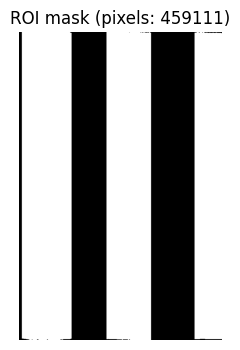

[DEBUG] ROI mask image saved → /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9/roi_mask_viz.png
[Step 4-3] Video & mask loaded + ROI visualization complete!


In [35]:
import matplotlib.pyplot as plt
from cotracker.utils.visualizer import read_video_from_path

# Function to load video as a NumPy array
def load_video_as_np(path: str) -> np.ndarray:
    arr = read_video_from_path(path)
    if arr is None:
        raise FileNotFoundError(f"[ERROR] Cannot load video: {path}")
    return arr

# Load video
video_np = load_video_as_np(VIDEO_PATH)  # shape = (T, H, W, 3)
num_frames, vid_h, vid_w, _ = video_np.shape
print(f"[INFO] Video shape: {video_np.shape}, Total frames: {num_frames}")

# Try loading mask file
mask_npy = None
try:
    mask_npy = np.load(MASK_PATH, allow_pickle=False)
    debug_np_array(mask_npy, name="[RAW MASK]")
except Exception as e:
    print(f"[WARN] Failed to load mask → {e}")
    USE_MASK_ROI = False
    mask_npy = None

# Convert to binary mask if enabled
if (mask_npy is not None) and USE_MASK_ROI:
    try:
        mask_bin = create_mask_bin(mask_npy, vid_h, vid_w, threshold=MASK_THRESHOLD)
        debug_np_array(mask_bin, name="[BIN MASK]")
        print(f"[INFO] mask_bin unique values = {np.unique(mask_bin)}")
    except Exception as e:
        print(f"[ERROR] Failed to convert mask: {e}")
        USE_MASK_ROI = False
        mask_bin = None
else:
    mask_bin = None
    USE_MASK_ROI = False
    print("[INFO] ROI not used (no mask or USE_MASK_ROI=False)")

# Utility: generate new output folder (e.g., exp, exp2, exp3, ...)
def get_new_output_folder(base_dir: str, prefix="exp") -> str:
    i = 1
    while True:
        name = prefix if i == 1 else f"{prefix}{i}"
        path = os.path.join(base_dir, name)
        if not os.path.exists(path):
            os.makedirs(path)
            return path
        i += 1

# Create output directory
out_dir = get_new_output_folder(OUTPUT_BASE_DIR, prefix="exp")
print(f"[INFO] Output folder → {out_dir}")

# Visualize ROI mask with coordinates
if USE_MASK_ROI:
    if mask_bin.ndim == 3:
        if 0 <= FORCED_MASK_FRAME_INDEX < mask_bin.shape[0]:
            mask_2d = mask_bin[FORCED_MASK_FRAME_INDEX]
        else:
            raise IndexError("FORCED_MASK_FRAME_INDEX exceeds 3D mask range.")
    elif mask_bin.ndim == 2:
        mask_2d = mask_bin
    else:
        raise ValueError("Unrecognized number of dimensions in mask_bin.")

    roi_pix_cnt = int((mask_2d > 0).sum())
    plt.figure(figsize=(6, 4))
    plt.title(f"ROI mask (pixels: {roi_pix_cnt})")
    plt.imshow(mask_2d, cmap='gray')
    plt.axis('off')
    maskviz_path = os.path.join(out_dir, "roi_mask_viz.png")
    plt.savefig(maskviz_path, dpi=100)
    plt.show()
    print(f"[DEBUG] ROI mask image saved → {maskviz_path}")

print("[Step 4-3] Video & mask loaded + ROI visualization complete!")


In [36]:
import torch
from cotracker.predictor import CoTrackerPredictor

# Set device
device_str = f"cuda:{GPU_IDS[0]}" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Device: {device_str}, GPU_IDS: {GPU_IDS}, DataParallel: {USE_DATA_PARALLEL}")

# Load model
model = CoTrackerPredictor(
    checkpoint=CHECKPOINT_PATH,
    offline=(not IS_ONLINE),
    v2=False,
    window_len=WINDOW_LEN
)
model.eval()

# Optional: use DataParallel if multiple GPUs
if USE_DATA_PARALLEL and len(GPU_IDS) > 1:
    model = nn.DataParallel(model, device_ids=GPU_IDS).to(device_str)
else:
    model.to(device_str)

print("✅ CoTracker model loaded successfully.")

# Sample points from 2D binary mask grid
def sample_points_mask_grid(mask_2d, spacing=10, max_pts=10000):
    h, w = mask_2d.shape
    coords = []
    for y in range(0, h, spacing):
        for x in range(0, w, spacing):
            if mask_2d[y, x] > 0:
                coords.append((x, y))
    coords_xy = np.array(coords, dtype=np.float32)

    # Limit number of points
    if len(coords_xy) > max_pts:
        coords_xy = coords_xy[:max_pts]
    return coords_xy

# Convert RGB video to 5D tensor for inference
def frames_to_5d_tensor(frames_np, out_h, out_w, device):
    T_ = frames_np.shape[0]
    frames_t = torch.from_numpy(frames_np).permute(0, 3, 1, 2).float().unsqueeze(0)
    frames_t = frames_t.permute(0, 2, 1, 3, 4)
    frames_t = F.interpolate(
        frames_t,
        size=(T_, out_h, out_w),
        mode='trilinear',
        align_corners=False
    )
    frames_t = frames_t.permute(0, 2, 1, 3, 4).to(device)
    print("[DEBUG] frames_to_5d_tensor =>")
    print(f"   -> Original frames_np shape = {frames_np.shape}")
    print(f"   -> out_h = {out_h}, out_w = {out_w}, T_ = {T_}")
    print_tensor_debug_info(frames_t, "Preprocessed video_tensor")
    return frames_t

# Main sliding inference loop
all_pred_tracks = []
all_pred_vis = []
chunk_offset = 0
num_frames_loaded = len(video_np)
print(f"[INFO] (window_len = {WINDOW_LEN}), Overlap = {CHUNK_OVERLAP}, Total frames = {num_frames_loaded}")
print(f"[INFO] DISCARD_INCOMPLETE_CHUNK = {DISCARD_INCOMPLETE_CHUNK}")

while True:
    start_f = chunk_offset
    end_f = chunk_offset + WINDOW_LEN
    if end_f > num_frames_loaded:
        if not DISCARD_INCOMPLETE_CHUNK:
            end_f = num_frames_loaded
        else:
            break
    if start_f >= num_frames_loaded:
        break

    chunk_np = video_np[start_f:end_f]
    real_len = chunk_np.shape[0]
    if real_len <= 0:
        break

    # ROI mask (for seed point sampling)
    if USE_MASK_ROI and (mask_bin is not None):
        if mask_bin.ndim == 3:
            if FORCED_MASK_FRAME_INDEX >= 0 and FORCED_MASK_FRAME_INDEX < mask_bin.shape[0]:
                mask_2d = mask_bin[FORCED_MASK_FRAME_INDEX]
            else:
                mask_2d = mask_bin[start_f]
        elif mask_bin.ndim == 2:
            mask_2d = mask_bin
        else:
            raise ValueError("Unexpected mask_bin shape.")

        coords0 = sample_points_mask_grid(mask_2d, spacing=5, max_pts=MAX_POINTS)
        roi_pix_cnt = (mask_2d > 0).sum()
        print(f"   -> ROI mask shape = {mask_2d.shape}")
        print(f"   -> ROI pixel count = {roi_pix_cnt}, Sampled coords = {coords0.shape[0]}")

    # Debug image output (save all frames or just the first)
    if SAVE_ALL_FRAMES_DEBUG:
        for fi in range(real_len):
            bgr = cv2.cvtColor(chunk_np[fi], cv2.COLOR_RGB2BGR)
            dbg = bgr.copy()
            if fi == 0:
                for (x, y) in coords0:
                    cv2.circle(dbg, (int(x), int(y)), 2, (0, 0, 255), -1)
            dbg_path = os.path.join(out_dir, f"chunk{start_f}_frame{fi}.png")
            cv2.imwrite(dbg_path, dbg)
    else:
        bgr0 = cv2.cvtColor(chunk_np[0], cv2.COLOR_RGB2BGR)
        for (x, y) in coords0:
            cv2.circle(bgr0, (int(x), int(y)), 2, (0, 0, 255), -1)
        dbg_path = os.path.join(out_dir, f"chunk{start_f}_frame0_points.png")
        cv2.imwrite(dbg_path, bgr0)

    # Prepare queries (t=0)
    N_ = coords0.shape[0]
    q_np = np.zeros((1, N_, 3), dtype=np.float32)
    q_np[0, :, 0] = 0  # query starts from frame 0
    q_np[0, :, 1:] = coords0
    q_t = torch.from_numpy(q_np).to(device_str)

    # Convert chunk to 5D tensor
    chunk_t = frames_to_5d_tensor(chunk_np, SPATIAL_RESIZE[0], SPATIAL_RESIZE[1], device_str)

    print(f"[INFO] Chunk: {start_f}-{end_f-1} (Length = {real_len}), #Points = {N_}")
    print("   -> Running model.forward() ...")

    with torch.no_grad():
        pred_tr, pred_vis = model(
            video=chunk_t,
            queries=q_t,
            segm_mask=None,
            grid_size=0,
            grid_query_frame=0,
            backward_tracking=False
        )
    all_pred_tracks.append(pred_tr.cpu())
    all_pred_vis.append(pred_vis.cpu())
    print(f"[INFO] => pred_tr shape = {tuple(pred_tr.shape)}, pred_vis = {tuple(pred_vis.shape)}")

    chunk_offset += (WINDOW_LEN - CHUNK_OVERLAP)

print("[Step 4-4] Sliding inference completed!")


[INFO] Device: cuda:0, GPU_IDS: [0], DataParallel: False
✅ CoTracker model loaded successfully.
[INFO] (window_len = 60), Overlap = 0, Total frames = 12
[INFO] DISCARD_INCOMPLETE_CHUNK = False
   -> ROI mask shape = (1080, 710)
   -> ROI pixel count = 459111, Sampled coords = 18338
[DEBUG] frames_to_5d_tensor =>
   -> Original frames_np shape = (12, 1080, 710, 3)
   -> out_h = 1080, out_w = 710, T_ = 12
   -> Preprocessed video_tensor: shape=(1, 12, 3, 1080, 710), dtype=torch.float32, device=cuda:0
      min=0.000, max=255.000
[INFO] Chunk: 0-11 (Length = 12), #Points = 18338
   -> Running model.forward() ...
[INFO] => pred_tr shape = (1, 12, 18338, 2), pred_vis = (1, 12, 18338)
[Step 4-4] Sliding inference completed!


In [ ]:
def compute_length_change(traj_2d):
    base= traj_2d[0]
    out=[]
    for i in range(traj_2d.shape[0]):
        out.append(np.linalg.norm(traj_2d[i]-base))
    return out

chunk_dfs=[]
global_frame_offset=0

for seg_idx,(seg_tr,seg_vis) in enumerate(zip(all_pred_tracks,all_pred_vis)):
    seg_tr = seg_tr.squeeze(0).numpy()  # (T,N,2)
    seg_vis= seg_vis.squeeze(0).numpy() # (T,N)
    T_,N_ = seg_tr.shape[0], seg_tr.shape[1]

    df_list=[]
    for pid in range(N_):
        coords = seg_tr[:,pid,:]
        if CALC_LENGTH_CHANGE:
            dist_= compute_length_change(coords)
        else:
            dist_= [0]*T_
        for f in range(T_):
            df_list.append({
                "GlobalFrame": global_frame_offset+f,
                "LocalFrame" : f,
                "ChunkID"    : seg_idx,
                "PointID"    : pid,
                "X": coords[f,0],
                "Y": coords[f,1],
                "LengthChange": dist_[f],
                "Visibility": float(seg_vis[f,pid])
            })
    global_frame_offset+=T_
    cdf = pd.DataFrame(df_list)
    chunk_dfs.append(cdf)

df_all= pd.concat(chunk_dfs, ignore_index=True)

if SAVE_AS_CSV:
    csv_path= os.path.join(out_dir, "TrackingResults.csv")
    df_all.to_csv(csv_path,index=False)
    print(f"[SAVE] CSV => {csv_path}, rows={len(df_all)}")

if SAVE_EXCEL:
    import openpyxl
    from pandas import ExcelWriter
    excel_path= os.path.join(out_dir,"TrackingResults.xlsx")
    if SPLIT_PER_CHUNK:
        with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
            for i, cdf in enumerate(chunk_dfs):
                cdf.to_excel(writer, sheet_name=f"Chunk{i}", index=False)
        print(f"[SAVE] Excel => chunk별 sheet: {excel_path}")
    else:
        df_all.to_excel(excel_path, index=False)
        print(f"[SAVE] Excel => single sheet: {excel_path}")

# 예시: pid=0 디버깅
if len(df_all) > 0:
    df_vis = df_all[df_all["Visibility"] > 0]
    avg_by_frame = df_vis.groupby("GlobalFrame")["LengthChange"].mean().reset_index()

    print("[DEBUG] Average length change per frame:")
    for _, row in avg_by_frame.iterrows():
        gf = int(row["GlobalFrame"])
        avg_len = row["LengthChange"]
        print(f"   Frame = {gf}, Avg. Length Change = {avg_len:.4f}")

# Save framewise average length change if enabled
if SAVE_AS_CSV:
    csv_path = os.path.join(out_dir, "TrackingResults.csv")
    df_all.to_csv(csv_path, index=False)
    print(f"[SAVE] CSV => {csv_path}, Rows = {len(df_all)}")

    avg_csv_path = os.path.join(out_dir, "Framewise_Avg_LengthChange.csv")
    avg_by_frame.to_csv(avg_csv_path, index=False)
    print(f"[SAVE] Framewise Avg. Length Change CSV => {avg_csv_path}")

print("[Step 4-5] Length change analysis, CSV/Excel export, and point debug complete!")

[SAVE] CSV => /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9/TrackingResults.csv, rows=220056
[DEBUG] 프레임별 평균 변위:
   Frame=0, 평균 변위=0.0000
   Frame=1, 평균 변위=6.2532
   Frame=2, 평균 변위=11.7373
   Frame=3, 평균 변위=19.6857
   Frame=4, 평균 변위=25.3776
   Frame=5, 평균 변위=32.8704
   Frame=6, 평균 변위=37.8867
   Frame=7, 평균 변위=32.8058
   Frame=8, 평균 변위=31.1693
   Frame=9, 평균 변위=20.8921
   Frame=10, 평균 변위=17.7800
   Frame=11, 평균 변위=12.2349
[SAVE] CSV => /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9/TrackingResults.csv, rows=220056
[SAVE] Framewise Avg. Length Change CSV => /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9/Framewise_Avg_LengthChange.csv
[Step 4-5] Length change analysis, CSV/Excel export, and point debug complete!


[VIDEO] saved => /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9/tracked_output.mp4


/tmp/ipykernel_3148628/1790841873.py:46: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.savefig(graph_path,dpi=150)
/tmp/ipykernel_3148628/1790841873.py:46: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  plt.savefig(graph_path,dpi=150)
/tmp/ipykernel_3148628/1790841873.py:46: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.savefig(graph_path,dpi=150)
/tmp/ipykernel_3148628/1790841873.py:46: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.savefig(graph_path,dpi=150)
/tmp/ipykernel_3148628/1790841873.py:46: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.savefig(graph_path,dpi=150)
/tmp/ipykernel_3148628/1790841873.py:46: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.savefig(graph_path,dpi=150)
/tmp/ipykernel_3148628/1790841873.py:46

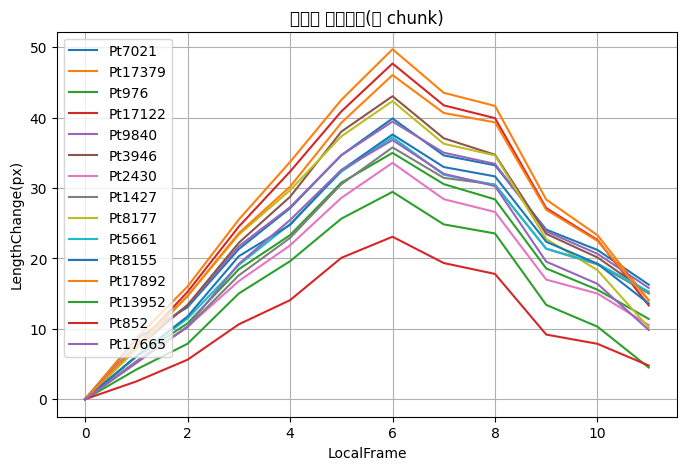

[GRAPH] 대표점 그래프 => /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9/rep_points_graph.png
[POINT VIS] single point 0 => /mnt/DATA3_SSD/Minsoo/Step_4_Tracking/exp9/pid0_traj
✅ [Cell 6] mp4 & 그래프 & 포인트별 시각화 완료!


In [ ]:
def render_tracked_video(video_np, df_all, out_path, fps=10, frame_stride=1,
                         dot_radius=3, dot_color=(0,0,255)):
    """
    Render tracking results onto the video and save as mp4.
    """
    T_ = video_np.shape[0]
    writer = imageio.get_writer(out_path, fps=fps)

    group = df_all.groupby("GlobalFrame")
    for f in range(0, T_, frame_stride):
        frame_rgb = video_np[f].copy()
        if f in group.groups:
            df_f = group.get_group(f)
            for _, row in df_f.iterrows():
                x = int(row["X"])
                y = int(row["Y"])
                cv2.circle(frame_rgb, (x, y), dot_radius, dot_color, -1)
        writer.append_data(frame_rgb)
    writer.close()
    print(f"[VIDEO] Saved video => {out_path}")

# Render tracked video
video_save_path = os.path.join(out_dir, SAVE_VIDEO_NAME)
render_tracked_video(
    video_np=video_np,
    df_all=df_all,
    out_path=video_save_path,
    fps=SAVE_FPS,
    frame_stride=FRAME_STRIDE_FOR_VIDEO
)

# Plot representative points' length change (first chunk)
if len(chunk_dfs) > 0 and len(chunk_dfs[0]) > 0:
    df_first = chunk_dfs[0]
    n_points = int(df_first["PointID"].max()) + 1
    pick_num = min(NUM_REP_POINTS, n_points)
    sample_ids = random.sample(range(n_points), pick_num)

    plt.figure(figsize=(8, 5))
    for pid in sample_ids:
        dsub = df_first[df_first["PointID"] == pid].sort_values("LocalFrame")
        plt.plot(dsub["LocalFrame"], dsub["LengthChange"], label=f"Pt{pid}")
    plt.title("Representative Points – Length Change (1st Chunk)")
    plt.xlabel("Local Frame")
    plt.ylabel("Length Change (px)")
    plt.legend()
    plt.grid(True)
    graph_path = os.path.join(out_dir, "rep_points_graph.png")
    plt.savefig(graph_path, dpi=150)
    plt.show()
    print(f"[GRAPH] Saved plot => {graph_path}")

# Visualize trajectory of specific point (e.g., pid = 0)
POINT_ID_DEBUG = 0
df_pid0 = df_all[df_all["PointID"] == POINT_ID_DEBUG].sort_values("GlobalFrame")
pid0_dir = os.path.join(out_dir, f"pid{POINT_ID_DEBUG}_traj")
os.makedirs(pid0_dir, exist_ok=True)

for _, row in df_pid0.iterrows():
    gf = int(row["GlobalFrame"])
    x_ = int(row["X"])
    y_ = int(row["Y"])
    frm_rgb = video_np[gf].copy()
    cv2.circle(frm_rgb, (x_, y_), 6, (255, 0, 0), -1)
    img_path = os.path.join(pid0_dir, f"frame_{gf:04d}.png")
    cv2.imwrite(img_path, frm_rgb)

print(f"[POINT VIS] Saved trajectory images for Point ID {POINT_ID_DEBUG} => {pid0_dir}")
print("[Step5-6] MP4 video, graph, and point trajectory visualization complete!")
